In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


# Poetry Analysis

The data was obtained from: https://www.kaggle.com/ultrajack/poetry-analysis-using-ai-machine-learning/data

In [2]:
poetry = pd.read_csv('/Users/admin/Documents/Thinkful_Projects/poetry.csv')

In [3]:
poetry.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


In [4]:
poetry.shape

(573, 5)

In [5]:
poetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 5 columns):
author       573 non-null object
content      573 non-null object
poem name    571 non-null object
age          573 non-null object
type         573 non-null object
dtypes: object(5)
memory usage: 22.5+ KB


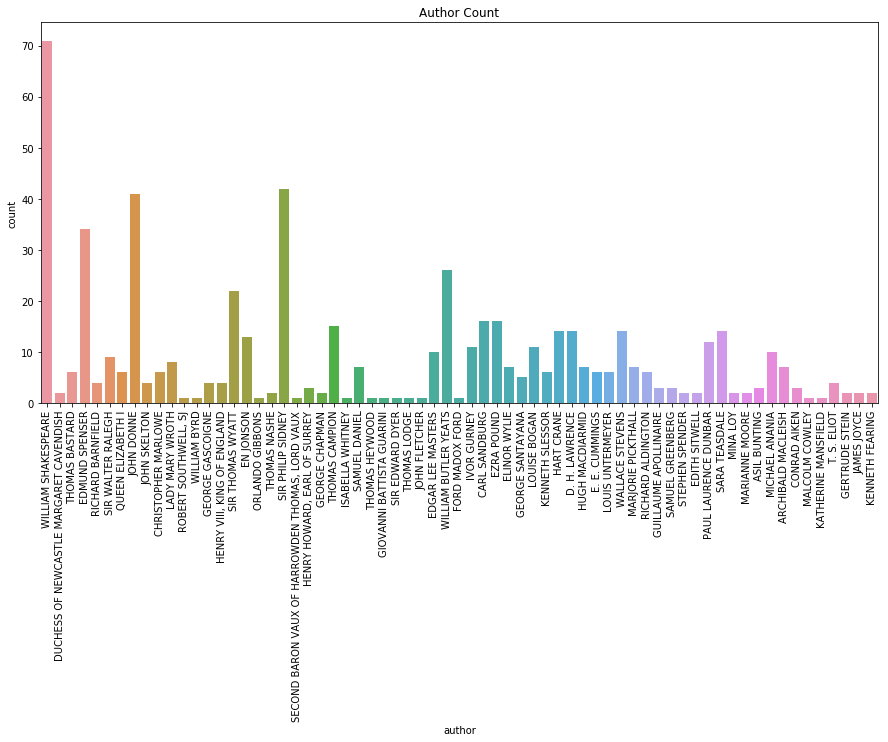

In [6]:
plt.figure(figsize=(15,7))
ax = sns.countplot(x=poetry['author'])
plt.xticks(rotation=90)
plt.title('Author Count')
plt.show()

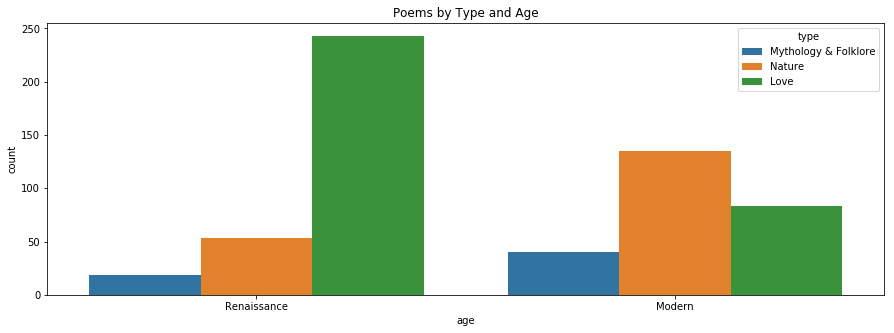

In [7]:
plt.figure(figsize=(15,5))

sns.countplot(x=poetry['age'], hue=poetry['type'])
plt.title('Poems by Type and Age')
plt.show()

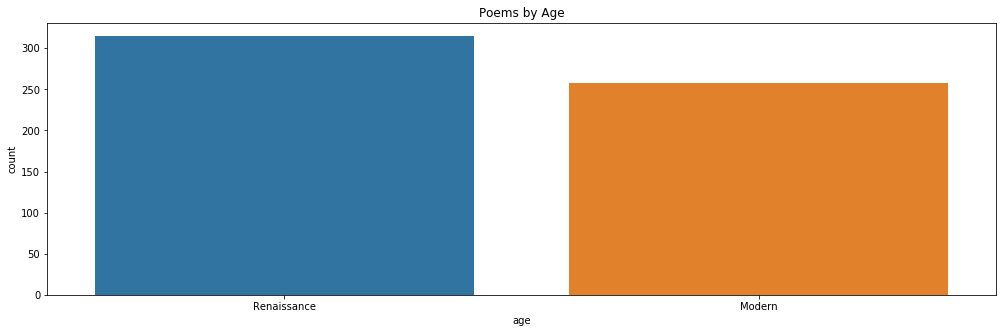

In [235]:
plt.figure(figsize=(17,5))

sns.countplot(x=poetry['age'])
plt.title('Poems by Age')
plt.show()


# Splitting The Data Into Train and Test Sets

In [236]:
X = poetry[['content', 'age']]
y = poetry['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

len(X_train)

401

In [237]:
len(X_test)

172

# I. Poem Preprocessing

## Punctuation Removal and Lemmatization

In [240]:
# write a function for preprocessing

nlp = spacy.load('en')
def processor(dataframe, column):
    poems_lemmas = []
    for entry in dataframe[column]:
        entry_parsed = nlp(entry)
        string = ''
        for token in entry_parsed:
            if not token.is_punct:
                string += token.lemma_ + ' '
        poems_lemmas.append(string)
    
    # removing new lines marking
    cleaned_poems = []
    for entry in poems_lemmas:
        entry = entry.replace('\n', '')
        cleaned_poems.append(entry)
        
    # removing 'r' marking
    cleaned_poems_fin = []
    for entry in cleaned_poems:
        entry = entry.replace('\r', '')
        cleaned_poems_fin.append(entry) 
    return cleaned_poems_fin

In [241]:
X_train_processed = processor(X_train, 'content')

In [242]:
len(X_train_processed)

401

In [243]:
X_train_processed[100]

"w'en daih 's chillun in de house  dey keep on a gittin tall  but de folk don seem to see  dat dey 's growin up at all  twell dey fin out some fine day  dat de gal have menc to grow  w'en dey notice as dey pass  dat de front gate 's saggin low  w'en de hinge creak an cry  an de bah go slantin down  -PRON- kin reckon dat hit 's time  fu to cas yo eye erroun  because daih be not no sputin dis  hit 's de true sign to show  dat daih 's cou'tin go on  w'en de old front gate sag low  oh -PRON- grumble an complain  an -PRON- prop dat gate up right  but -PRON- notice right nex day  dat hit be in de same old plight  so -PRON- fin dat hit be a rule  an daih ain no use to blow  w'en de gal be growin up  dat de front gate will sag low  den -PRON- t'ink o yo young day  w'en -PRON- cou't sally jane  an -PRON- so't o feel ashamed  fu to grumble an complain  because yo ricerlection say  an -PRON- know hit wo'ds be so  dat huh pappy have a time  wid -PRON- front gate saggin low  so -PRON- jes look on a

In [244]:
type(X_train_processed[100])

str

# II. Feature Generation: TF_IDF

In [245]:
vectorizer = TfidfVectorizer(max_df=0.8, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least five times
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [246]:
X_train_tfidf=vectorizer.fit_transform(X_train_processed)

print("Number of features: %d" % X_train_tfidf.get_shape()[1])

Number of features: 3462


## Latent Semantic Analysis and Normalization

In [247]:
# reduce compress feature space and normalize our train set
svd= TruncatedSVD(300)
lsa = make_pipeline(svd, Normalizer(copy=False))


X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Variance captured by all components:", "%.2f" %total_variance)

Variance captured by all components: 0.96


# III. APPLYING MACHINE LEARNING ALGORITHMS

### CROSS-VALIDATION ON THE TRAIN SET

### 1. Logistic Regression ('l1' penalty)

In [248]:
scores = []
Cs = []
for value in [0.001,0.01,0.1,1,10,100]:
    lr = LogisticRegression(C=value)
    score = np.mean(cross_val_score(lr, 
                                    X_train_lsa, 
                                    y_train,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [249]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.977667,10.000
1,0.977266,100.000
2,0.974411,1.000
3,0.960099,0.100
4,0.948070,0.010
5,0.942015,0.001


### 2. Random Forest Classifier

In [251]:
scores = []
parameters = []

est_number = [100, 500,700, 1000, 1500] 

for value in est_number:
    rfc = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = value)
    score = np.mean(cross_val_score(rfc, 
                                    X_train_lsa, 
                                    y_train, n_jobs=-1,
                                    scoring = 'roc_auc'))
    scores.append(score)
    parameters.append(value)

In [252]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.951619,1000
1,0.950861,700
2,0.950628,1500
3,0.947758,500
4,0.932472,100


In [253]:
scores = []
parameters = []

depth = [6, 8, 12, 20, 50] 

for value in depth:
    rfc = RandomForestClassifier(n_jobs = -1, 
                                 n_estimators = 1000, 
                                 max_depth = value)
    score = np.mean(cross_val_score(rfc, 
                                    X_train_lsa, 
                                    y_train, n_jobs=-1,
                                    scoring='roc_auc'))
    scores.append(score)
    parameters.append(value)

In [254]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.951703,12
1,0.951619,20
2,0.951619,50
3,0.949633,8
4,0.947721,6


### 3. Gradient Boosting Classifier

In [255]:
scores = []
parameters = []

est_number = [100, 500,700, 1000, 1500] 

for value in est_number:
    gbc = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = value)
    
    score = np.mean(cross_val_score(
                        gbc, 
                        X_train_lsa, 
                        y_train,  
                        n_jobs=-1,
                        scoring='roc_auc'))
    
    scores.append(score)
    parameters.append(value)

In [256]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.963933,500
1,0.963933,700
2,0.963933,1000
3,0.963933,1500
4,0.960997,100


In [257]:
scores = []
parameters = []

depth = [4, 6, 8, 10] 

for value in depth:
    gbc = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = 500,
                                    max_depth = value)
    
    score = np.mean(cross_val_score(
                        gbc, 
                        X_train_lsa, 
                        y_train,  
                        n_jobs=-1,
                        scoring='roc_auc'))
    
    scores.append(score)
    parameters.append(value)

In [258]:
df = pd.DataFrame(scores)
df['params'] = parameters
df.columns=['scores', 'params']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,params
0,0.956424,4
1,0.914434,6
2,0.913180,8
3,0.912643,10


### 4. XGBoost

In [259]:
n_est = []
scores = []

for value in [100, 500, 700, 1000]:
    xgb = XGBClassifier(n_jobs = -1,  
                        n_estimators = value, 
                        booster= 'gbtree')
    score = np.mean(cross_val_score(xgb, 
                                    X_train_lsa, 
                                    y_train, 
                                    n_jobs=-1, 
                                    scoring='roc_auc'
                                   ))
    scores.append(score)
    n_est.append(value)

In [260]:
df_xgb = pd.DataFrame(scores, columns = ['scores'])
df_xgb['n_est'] = n_est
df_xgb.sort_values(by=['scores'], ascending=False)

,scores,n_est
1,0.960309,500
2,0.960309,700
3,0.960309,1000
0,0.956399,100


In [261]:
max_depth = []
scores = []

for value in [2, 4, 6, 8]:
    xgb = XGBClassifier(n_jobs = -1,  
                        n_estimators = 500, 
                        booster= 'gbtree',
                        max_depth = value)
    score = np.mean(cross_val_score(xgb, 
                                    X_train_lsa, 
                                    y_train, 
                                    n_jobs=-1,
                                    scoring='roc_auc'))
    scores.append(score)
    max_depth.append(value)

In [262]:
df_xgb = pd.DataFrame(scores, columns = ['scores'])
df_xgb['max_depth'] = max_depth
df_xgb.sort_values(by=['scores'], ascending=False)

,scores,max_depth
0,0.965048,2
1,0.962561,4
3,0.960214,8
2,0.958975,6


In [263]:
learning_rates = []
scores = []

for value in [0.5, 0.1, 0.01]:
    xgb = XGBClassifier(n_jobs = -1,  
                        n_estimators = 500, 
                        booster= 'gbtree',
                        max_depth = 2,
                       learning_rate = value)
    score = np.mean(cross_val_score(xgb, 
                                    X_train_lsa, 
                                    y_train, 
                                    n_jobs=-1,
                                    scoring='roc_auc'))
    scores.append(score)
    learning_rates.append(value)

In [264]:
df_xgb = pd.DataFrame(scores, columns = ['scores'])
df_xgb['learning_rate'] = learning_rates
df_xgb.sort_values(by=['scores'], ascending=False)

,scores,learning_rate
1,0.965048,0.10
2,0.955120,0.01
0,0.952024,0.50


### 5. Support Vector Machine Classifier

In [401]:
scores = []
Cs = []
for value in [0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]:
    svc = SVC(C=value)
    score = np.mean(cross_val_score(svc, 
                                    X_train_lsa, 
                                    y_train,
                                   scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [402]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.975756,100.000
1,0.970142,1000.000
2,0.970142,10000.000
3,0.968958,10.000
4,0.968881,20.000
5,0.968727,1.000
6,0.968277,0.100
7,0.952800,0.010
8,0.951814,0.001


In [403]:
scores = []
gammas = []
for value in [0.001, 0.01, 0.1, 1, 'auto']:
    svc = SVC(C=1e2, gamma=value)
    score = np.mean(cross_val_score(svc, X_train_lsa, y_train, scoring='roc_auc'))
    scores.append(score)
    gammas.append(value)

In [404]:
df  =  pd.DataFrame(scores)
df['gammas'] = gammas
df.columns=['scores', 'gammas']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,gammas
0,0.977286,1
1,0.975756,auto
2,0.972971,0.1
3,0.971526,0.01
4,0.971106,0.001


# IV. VALIDATING ALGORITHM PERFORMANCE ON THE TEST SET

In [269]:
X_test_processed = processor(X_test, 'content')

In [270]:
# applying the vectorizer to the test set
X_test_tfidf=vectorizer.transform(X_test_processed)

In [271]:
# transforming the test set
X_test_lsa = lsa.transform(X_test_tfidf)

### 1. Logistic Regression

In [277]:
from sklearn.metrics import roc_auc_score

lr_test = LogisticRegression(C=10)
lr_test.fit(X_train_lsa, y_train) 

print(roc_auc_score(y_test, lr_test.predict_proba(X_test_lsa)[:, 1]))

0.9977002164502164


In [278]:
from sklearn.metrics import confusion_matrix
lr_pred = lr_test.predict(X_test_lsa) 
matrix_lr = confusion_matrix(y_test, lr_pred)

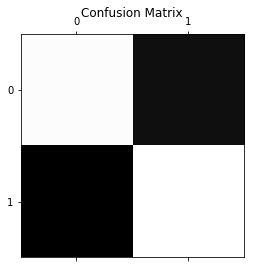

In [279]:
plt.matshow(matrix_lr, cmap = plt.cm.gray)
plt.title('Confusion Matrix')
plt.show()

### 2. Random Forest Classifier

In [281]:
rfc_test = RandomForestClassifier(n_jobs = -1, 
                            n_estimators = 1000, 
                            max_depth = 12)
rfc_test.fit(X_train_lsa, y_train) 

print(roc_auc_score(y_test, rfc_test.predict_proba(X_test_lsa)[:, 1]))

0.9778138528138528


### 3. Gradient Boosting

In [282]:
gbc_test = GradientBoostingClassifier(loss = 'deviance',
                                    n_estimators = 500,
                                    max_depth = 4)
gbc_test.fit(X_train_lsa, y_train) 

print(roc_auc_score(y_test, gbc_test.predict_proba(X_test_lsa)[:, 1]))

0.972267316017316


### 4. XGBoost

In [283]:
xgb_test = XGBClassifier(n_jobs = -1,  
                        n_estimators = 500, 
                        booster= 'gbtree',
                        max_depth = 2,
                        learning_rate = 0.1)

xgb_test.fit(X_train_lsa, y_train) 
print(roc_auc_score(y_test, xgb_test.predict_proba(X_test_lsa)[:, 1]))

0.9738906926406927


### 5. Support Vector Machine Classifier

In [405]:
svc_test = SVC(C=1e2, gamma=1, probability=True)

svc_test.fit(X_train_lsa, y_train) 

print(roc_auc_score(y_test, svc_test.predict_proba(X_test_lsa)[:, 1]))

0.9987824675324676


In [286]:
svc_pred = svc_test.predict(X_test_lsa) 
matrix_one = confusion_matrix(y_test, svc_pred)

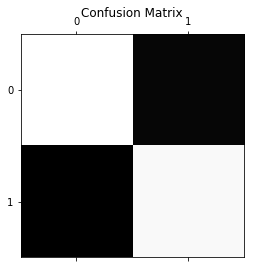

In [287]:
plt.matshow(matrix_one, cmap = plt.cm.gray)
plt.title('Confusion Matrix')
plt.show()

# IV. Feature Generation: word2vec

 `Transformation of our current X_train into a different format for word2vec: each word is now an individual string`

In [288]:
def parser(document): 
    doc = nlp(document)
    test_list = []
    for entry in doc:
        if (
            not entry.is_punct
        and not entry.is_stop):
            test_list.append(str(entry.lemma_))
    return test_list

In [289]:
X_mod = []
for entry in X_train['content']:
    result = parser(entry)
    X_mod.append(result)

In [290]:
len(X_train['content'])

401

In [291]:
len(X_mod)

401

In [441]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    X_mod,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=5,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=400,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [442]:
vocab = model.wv.vocab.keys()
print(len(vocab))

1495


In [445]:
# we need to get the resultant vector which individual word-vectors
def result_vector(sentence):
    result = np.zeros(400)
    for word in sentence:
        if word in vocab:
            result+=model.wv[word]
    return result

In [446]:
# create the list with new features

X_fin = []
for sent in X_mod:
        vec = result_vector(sent)
        X_fin.append(vec)

In [447]:
len(X_fin)

401

# Logistic Regression

In [448]:
scores = []
Cs = []
for value in [0.001,0.01,0.1,1,10,100]:
    lr = LogisticRegression(C=value)
    score = np.mean(cross_val_score(lr, 
                                    X_fin, 
                                    y_train,
                                   scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [449]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.953318,100.000
1,0.946975,10.000
2,0.922085,1.000
3,0.887831,0.100
4,0.839725,0.010
5,0.807955,0.001


In [450]:
# we now need to get our test set to the appropriate format
X_mod_test = []
for entry in X_test['content']:
    result = parser(entry)
    X_mod_test.append(result)

In [451]:
len(X_test)

172

In [452]:
len(X_mod_test)

172

In [453]:
X_fin_test = []
for sent in X_mod_test:
    vec = result_vector(sent)
    X_fin_test.append(vec)

In [454]:
# test set validation

lr_test = LogisticRegression(C=100)

lr_test.fit(X_fin, y_train)
print(roc_auc_score(y_test, lr_test.predict_proba(X_fin_test)[:, 1]))

0.9867424242424242


In [455]:
scores = []
Cs = []
for value in [0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]:
    svc = SVC(C=value)
    score = np.mean(cross_val_score(svc, 
                                    X_fin, 
                                    y_train,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [456]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.838890,100.000
1,0.830064,20.000
2,0.826487,10.000
3,0.824229,1000.000
4,0.812878,1.000
5,0.797603,10000.000
6,0.790141,0.100
7,0.782785,0.010
8,0.779050,0.001


In [457]:
scores = []
gammas = []
for value in [0.001, 0.01, 0.1, 1, 'auto']:
    svc = SVC(C=1e2, gamma=value)
    score = np.mean(cross_val_score(svc, 
                                    X_fin, 
                                    y_train, 
                                    scoring='roc_auc'))
    scores.append(score)
    gammas.append(value)

In [458]:
df  =  pd.DataFrame(scores)
df['gammas'] = gammas
df.columns=['scores', 'gammas']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,gammas
0,0.843943,0.001
1,0.838890,auto
2,0.817039,1
3,0.807556,0.1
4,0.795086,0.01


In [459]:
svc_test = SVC(C=1e2, gamma=1e-3, probability=True)

svc_test.fit(X_fin, y_train) 

print(roc_auc_score(y_test, svc_test.predict_proba(X_fin_test)[:, 1]))

0.8614718614718614


# Part II. Prediction of Type

In [521]:
# since we know we are dealing with class imbalance, it is best to convert type into binary features: love vs. not love
poetry['type'] = np.where(poetry['type'] == 'Love', 1, 0)

In [522]:
poetry.type.value_counts()

1    326
0    247
Name: type, dtype: int64

In [523]:
X_type = poetry[['content', 'type']]
y_type = poetry['type'] # this time we are predicting the type, not the age

X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_type, y_type, test_size=0.2, random_state=0)

len(X_train_type)

458

In [524]:
X_train_type['type'].value_counts()

1    265
0    193
Name: type, dtype: int64

In [525]:
X_train_type_processed = processor(X_train_type, 'content')

In [526]:
X_train_type_processed[0]

'michael anania tracings from selected poems copyright   1994 by michael anania use by permission of asphodel press acorn alliance '

In [527]:
X_train_tfidf_type=vectorizer.fit_transform(X_train_type_processed)

print("Number of features: %d" % X_train_tfidf_type.get_shape()[1])

Number of features: 3688


In [528]:
X_train_lsa_type = lsa.fit_transform(X_train_tfidf_type)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Variance captured by all components:", "%.2f" %total_variance)

Variance captured by all components: 0.93


In [529]:
scores = []
Cs = []
for value in [0.001,0.01,0.1,1,10,100]:
    lr = LogisticRegression(C=value)
    score = np.mean(cross_val_score(lr, 
                                    X_train_lsa_type, 
                                    y_train_type,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

In [530]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.777988,1.000
1,0.770076,0.100
2,0.759171,0.010
3,0.753350,10.000
4,0.751879,0.001
5,0.729953,100.000


In [531]:
X_test_processed = processor(X_test_type, 'content')

In [532]:
X_test_tfidf_type=vectorizer.transform(X_test_processed)

print("Number of features: %d" % X_train_tfidf_ren.get_shape()[1])

Number of features: 2671


In [533]:
X_test_lsa_type = lsa.transform(X_test_tfidf_type)

In [573]:

lr_test = LogisticRegression(C=1)
lr_test.fit(X_train_lsa_type, y_train_type)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [574]:
print(roc_auc_score(y_test_type, lr_test.predict_proba(X_test_lsa_type)[:, 1]))

0.8595931997571342


In [559]:
def prediction(classifier, feature_set, prob):
    y_predicted = []
    for i in classifier.predict_proba(feature_set)[:, 1]:
        if i > prob:
            y_predicted.append(1)
        else: 
            y_predicted.append(0)
    return y_predicted

In [593]:
lr_pred = prediction(lr_test, X_test_lsa_type, 0.7)

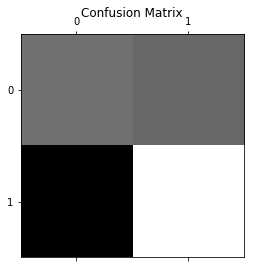

In [594]:
lr_pred = lr_test.predict(X_test_lsa_type) 
matrix_lr = confusion_matrix(y_test_type, lr_pred)

plt.matshow(matrix_lr, cmap = plt.cm.gray)
plt.title('Confusion Matrix')
plt.show()

In [595]:
confusion_matrix(y_test_type, lr_pred)

array([[28, 26],
       [ 7, 54]])

In [552]:
scores = []
Cs = []
for value in [0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]:
    svc = SVC(C=value)
    score = np.mean(cross_val_score(svc, 
                                    X_train_lsa_type, 
                                    y_train_type,
                                    scoring='roc_auc'))
    scores.append(score)
    Cs.append(value)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

In [553]:
df  =  pd.DataFrame(scores)
df['Cs'] = Cs
df.columns=['scores', 'Cs']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,Cs
0,0.766080,0.010
1,0.765477,0.001
2,0.764170,100.000
3,0.763787,0.100
4,0.762281,20.000
5,0.762224,10.000
6,0.761960,1.000
7,0.724818,1000.000
8,0.717051,10000.000


In [554]:
scores = []
gammas = []
for value in [0.001, 0.01, 0.1, 1, 'auto']:
    svc = SVC(C=0.01, gamma=value)
    score = np.mean(cross_val_score(svc, 
                                    X_train_lsa_type, 
                                    y_train_type,
                                    scoring='roc_auc'))
    scores.append(score)
    gammas.append(value)

In [555]:
df  =  pd.DataFrame(scores)
df['gammas'] = gammas
df.columns=['scores', 'gammas']

df.sort_values(by = 'scores', ascending=False).reset_index(drop=True)

,scores,gammas
0,0.766080,auto
1,0.765868,0.01
2,0.765746,0.001
3,0.761032,0.1
4,0.729728,1


In [556]:
svc_test = SVC(C=0.01, gamma='auto', probability=True)

svc_test.fit(X_train_lsa_type, y_train_type)


In [557]:
print(roc_auc_score(y_test_type, svc_test.predict_proba(X_test_lsa_type)[:, 1]))

0.8219489981785063


In [569]:
svc_predicted = prediction(svc_test, X_test_lsa_type, 0.7)

In [570]:
matrix_svc = confusion_matrix(y_test_type, svc_predicted)

In [571]:
confusion_matrix(y_test_type, svc_predicted)

array([[45,  9],
       [18, 43]])

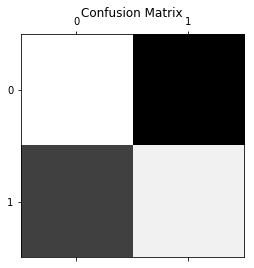

In [572]:
plt.matshow(matrix_svc, cmap = plt.cm.gray)
plt.title('Confusion Matrix')
plt.show()